Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

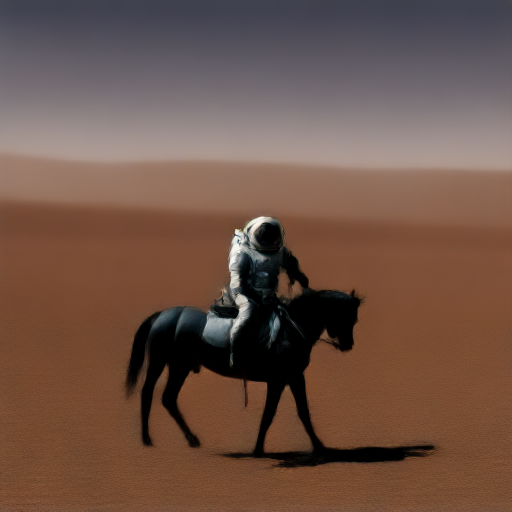

In [18]:
import torch
from diffusers import AutoencoderKL, StableDiffusionPipeline
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

model_id = "runwayml/stable-diffusion-v1-5"
decoder_id = "ostris/vae-kl-f8-d16"
adapter_id = "ostris/16ch-VAE-Adapters"
adapter_ckpt = "16ch-VAE-Adapter-SD15-alpha.safetensors"
dtype = torch.float16

vae = AutoencoderKL.from_pretrained(decoder_id, torch_dtype=dtype)
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, vae=vae, torch_dtype=torch.float16, safety_checker=None
)

ckpt_file = hf_hub_download(adapter_id, adapter_ckpt)
ckpt = load_file(ckpt_file)

# lora_state_dict = {k: v for k, v in ckpt.items() if "lora" in k}
unet_state_dict = {k.replace("unet_", ""): v for k, v in ckpt.items() if "unet_" in k}

pipe.unet.conv_in = torch.nn.Conv2d(16, 320, 3, 1, 1)
pipe.unet.conv_out = torch.nn.Conv2d(320, 16, 3, 1, 1)
pipe.unet.load_state_dict(unet_state_dict, strict=False)
pipe.unet.conv_in.to(dtype)
pipe.unet.conv_out.to(dtype)
pipe.unet.config.in_channels = 16
pipe.unet.config.out_channels = 16

# pipe.load_lora_weights(lora_state_dict)
# pipe.fuse_lora()

pipe = pipe.to("cuda")
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt,).images[0]
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

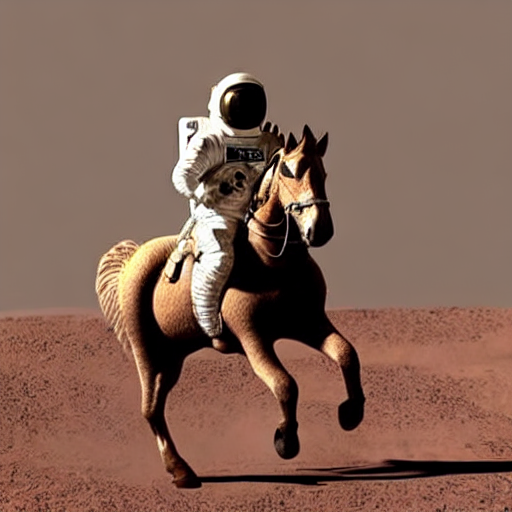

In [13]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]
image

In [2]:
from diffusers import AutoencoderKL
import torch

In [3]:
vae = AutoencoderKL.from_pretrained('stable-diffusion-v1-5/stable-diffusion-inpainting', subfolder='vae', torch_dtype=torch.float16).to('cuda')

An error occurred while trying to fetch stable-diffusion-v1-5/stable-diffusion-inpainting: stable-diffusion-v1-5/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [4]:
vae

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

In [9]:
x = torch.randn(1, 3, 512, 384, dtype=torch.float16).to('cuda')
out = vae.encode(x)
out.latent_dist.sample().shape

torch.Size([1, 4, 64, 48])